# Clustering

In this example we will do some simple cell clustering based on multiband imagery.

## Setup 

First some setup:

In [2]:
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()
    
resource_dir = Path('./samples').resolve()
# Utility for reading imagery from our test data set
filenamePattern = "L8-B{}-Elkton-VA.tiff"
bandNumbers = range(1, 5)
bandColNames = list(map(lambda n: 'band_{}'.format(n), bandNumbers))

def readTiff(name):
    return resource_dir.joinpath(filenamePattern.format(name)).as_uri()

## Loading Data

The first step is to load multiple bands of imagery and construct a single RasterFrame from them.

In [3]:
from functools import reduce
joinedRF = reduce(lambda rf1, rf2: rf1.asRF().spatialJoin(rf2.drop('bounds').drop('metadata')),
                  map(lambda bf: spark.read.geotiff(bf[1]) \
                      .withColumnRenamed('tile', 'band_{}'.format(bf[0])),
                  map(lambda b: (b, readTiff(b)), bandNumbers)))

We should see a `spatial_key` column, `bounds`, `metadata`, and 4 columns of tiles, representing our four bands.

In [149]:
joinedRF.printSchema()

root
 |-- spatial_key: struct (nullable = false)
 |    |-- col: integer (nullable = false)
 |    |-- row: integer (nullable = false)
 |-- bounds: polygon (nullable = true)
 |-- metadata: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = false)
 |-- band_1: rf_tile (nullable = false)
 |-- band_2: rf_tile (nullable = false)
 |-- band_3: rf_tile (nullable = false)
 |-- band_4: rf_tile (nullable = false)



## ML Pipeline 

SparkML requires that each observation be in its own row, and those
observations be packed into a single `Vector`. The first step is to
"explode" the tiles into a single row per cell/pixel.

In [4]:
exploder = TileExploder()

To "vectorize" the the band columns, as required by SparkML, we use the SparkML 
`VectorAssembler`. We then configure our algorithm, create the transformation pipeline,
and train our model. (Note: the selected value of *K* below is arbitrary.) 

In [5]:
assembler = VectorAssembler() \
    .setInputCols(bandColNames) \
    .setOutputCol("features")

# Configure our clustering algorithm
k = 5
kmeans = KMeans().setK(k)

# Combine the two stages
pipeline = Pipeline().setStages([exploder, assembler, kmeans])

# Compute clusters
model = pipeline.fit(joinedRF)

## Model Evaluation

Once trained, the model can be saved off for later use, or used immediately on the same
data we used to compute the model. First we run the data through the model to assign 
cluster IDs to each cell.

In [6]:
clustered = model.transform(joinedRF)
clustered.show(5)

+-----------+--------------------+--------------------+------------+---------+-------+------+------+------+--------------------+----------+
|spatial_key|              bounds|            metadata|column_index|row_index| band_1|band_2|band_3|band_4|            features|prediction|
+-----------+--------------------+--------------------+------------+---------+-------+------+------+------+--------------------+----------+
|      [0,0]|POLYGON ((703986....|Map(AREA_OR_POINT...|           0|        0| 9470.0|8491.0|7805.0|6697.0|[9470.0,8491.0,78...|         0|
|      [0,0]|POLYGON ((703986....|Map(AREA_OR_POINT...|           1|        0| 9566.0|8607.0|8046.0|6898.0|[9566.0,8607.0,80...|         0|
|      [0,0]|POLYGON ((703986....|Map(AREA_OR_POINT...|           2|        0| 9703.0|8808.0|8377.0|7222.0|[9703.0,8808.0,83...|         2|
|      [0,0]|POLYGON ((703986....|Map(AREA_OR_POINT...|           3|        0| 9856.0|8983.0|8565.0|7557.0|[9856.0,8983.0,85...|         2|
|      [0,0]|POLYGON

If we want to inspect the model statistics, the SparkML API requires us to go
through this unfortunate contortion:

In [7]:
clusterResults = list(filter(lambda x: str(x).startswith('KMeans'), model.stages))[0]

Compute sum of squared distances of points to their nearest center:

In [8]:
metric = clusterResults.computeCost(clustered)
print("Within set sum of squared errors: %s" % metric)

Within set sum of squared errors: 10450156759.53996


## Visualizing Results

The predictions are in a DataFrame with each row representing a separate pixel. 
To assemble a raster to visualize the cluster assignments, we have to go through a
multi-stage process to get the data back in tile form, and from there to combined
raster form.

First, we get the DataFrame back into RasterFrame form:

In [9]:
tlm = joinedRF.tileLayerMetadata()
layout = tlm['layoutDefinition']['tileLayout']

retiled = clustered.groupBy('spatial_key').agg(
    assembleTile('column_index', 'row_index', 'prediction',
        layout['tileCols'], layout['tileRows'], 'int8')
)

In [10]:
rf = retiled.asRF('spatial_key', tlm)
rf.printSchema()
rf.show()

root
 |-- spatial_key: struct (nullable = false)
 |    |-- col: integer (nullable = false)
 |    |-- row: integer (nullable = false)
 |-- prediction: rf_tile (nullable = true)

+-----------+--------------------+
|spatial_key|          prediction|
+-----------+--------------------+
|      [0,0]|ByteConstantNoDat...|
+-----------+--------------------+



To render our visualization, we convert to a raster first, which gives us a 1-D array with all the cell values. We then reshape the raster into a 2d array and use an
matplotlib colormap to assign each discrete cluster a different color.

In [11]:
# takes a while
raster = np.asarray(list(rf.toIntRaster('prediction', 186, 169)))

In [12]:
pixels = np.reshape(raster, (169, 186))

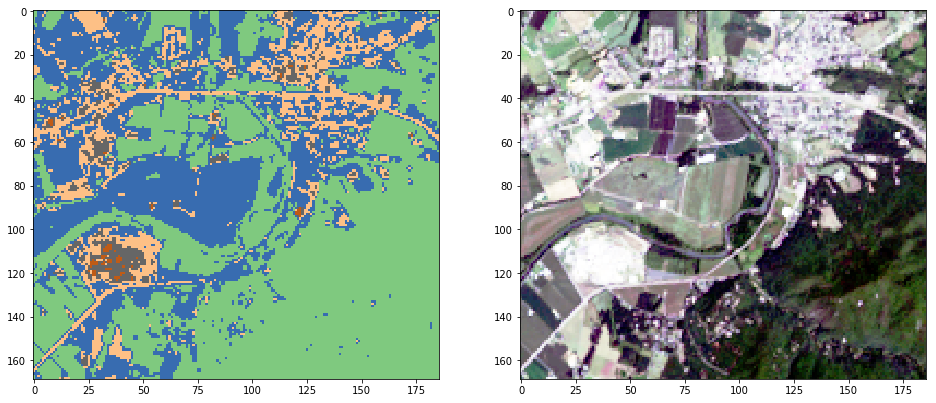

In [62]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(16,16))
fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(pixels)
imgplot.set_cmap('Accent')
fig.add_subplot(1, 2, 2)
pixels2 = mpl.pyplot.imread("pics/L8-RGB-VA.png")
imgplot = plt.imshow(pixels2)


The colors in the first picture are just the colormap's representation of the clusters assigned by the model, which are ints between 0 and 4, inclusive. The picture on the right is an RGB image of the scene. As we can see, brown clusters appear to be small centers of intense urban activity. Gray clusters are urban activity, light orange corresponds closely to roads and pavement, blue appears to be farmland, and green matches closely with forested regions.